In [5]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from random import randint

from tensorflow import keras

from tensorflow.keras import layers

from quant_invest_lab.data_provider import download_crypto_historical_data

# Transformer encoder


In [2]:
symbol = "BTC-USDT"

df = download_crypto_historical_data(symbol, "1hour").loc["2020-11-20":]
df["Log_Close"] = np.log(df.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df["Returns"] = df.Close.pct_change()
df["Log_Returns"] = df.Log_Close.pct_change()
df["Log_Volume"] = np.log(np.abs(df.Volume.apply(lambda x: 1.0 if x == 0.0 else x)))
df["Vol20"] = df.Log_Returns.rolling(20).std()
df["EMA20"] = df.Close.ewm(20).mean()
df["Target"] = (df["Close"].shift(-5) > df["Close"]).astype(int)
df.dropna(inplace=True)

df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Close,Log_Returns,Log_Volume,Vol20,EMA20,Target
Date,,,,,,,,,,,,,,
2020-11-20 20:00:00,1.605899e+09,18582.6,18626.1,18658.0,18532.6,37.037587,6.893380e+05,0.002341,9.832319,0.000238,13.443487,0.000658,18338.482479,1
2020-11-20 21:00:00,1.605902e+09,18626.2,18627.1,18687.6,18558.7,48.514027,9.047119e+05,0.000054,9.832373,0.000005,13.715372,0.000654,18359.364784,1
2020-11-20 22:00:00,1.605906e+09,18627.0,18576.5,18645.1,18512.4,58.444076,1.086463e+06,-0.002716,9.829653,-0.000277,13.898438,0.000633,18374.695941,1
2020-11-20 23:00:00,1.605910e+09,18576.5,18617.3,18619.7,18488.7,51.350270,9.529672e+05,0.002196,9.831847,0.000223,13.767336,0.000631,18391.440450,1
2020-11-21 00:00:00,1.605913e+09,18617.3,18659.4,18721.5,18550.9,95.569442,1.782114e+06,0.002261,9.834105,0.000230,14.393311,0.000629,18409.547487,0


In [3]:
std_scaler = StandardScaler()

X, y = (
    std_scaler.fit_transform(df.drop(columns=["Target", "Timestamp"]).values),
    df["Target"].values,
)  # to_categorical(df['Target'].values)

n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X.reshape((X.shape[0], X.shape[1], 1)), y, test_size=0.2, shuffle=False
)

x_train, y_train

(array([[[-1.20238424],
         [-1.19926441],
         [-1.20349812],
         ...,
         [-2.4726221 ],
         [ 0.03807073],
         [-1.2218012 ]],
 
        [[-1.19920121],
         [-1.19919141],
         [-1.20134978],
         ...,
         [-2.19621966],
         [ 0.02668771],
         [-1.22027399]],
 
        [[-1.1991428 ],
         [-1.20288555],
         [-1.20443439],
         ...,
         [-2.01011154],
         [-0.02994996],
         [-1.21915276]],
 
        ...,
 
        [[-1.34330626],
         [-1.34010205],
         [-1.34495478],
         ...,
         [-0.30092126],
         [-0.70167008],
         [-1.34698263]],
 
        [[-1.34011593],
         [-1.33973701],
         [-1.34235645],
         ...,
         [-0.68656722],
         [-0.80062446],
         [-1.3467208 ]],
 
        [[-1.3396779 ],
         [-1.34577468],
         [-1.34497655],
         ...,
         [-0.24941212],
         [-0.74979116],
         [-1.34675945]]]),
 array([1, 1, 1, ..

In [29]:

"""
We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.
The projection layers are implemented through `keras.layers.Conv1D`.
"""


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(
        x
    )  # layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


"""
## Train and evaluate
"""

input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",  # loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # AdamW or NovoGrad
    metrics=["accuracy"],  # metrics=["sparse_categorical_accuracy"],
)


model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
209/209 [==============================] - 76s 296ms/step - loss: 0.7093 - accuracy: 0.5052 - val_loss: 0.7166 - val_accuracy: 0.4864
Epoch 2/200
209/209 [==============================] - 66s 314ms/step - loss: 0.7069 - accuracy: 0.4957 - val_loss: 0.7092 - val_accuracy: 0.4855
Epoch 3/200
209/209 [==============================] - 99s 472ms/step - loss: 0.7015 - accuracy: 0.5102 - val_loss: 0.7052 - val_accuracy: 0.4831
Epoch 4/200
209/209 [==============================] - 96s 459ms/step - loss: 0.6987 - accuracy: 0.5127 - val_loss: 0.7022 - val_accuracy: 0.4825
Epoch 5/200
209/209 [==============================] - 99s 476ms/step - loss: 0.6993 - accuracy: 0.5076 - val_loss: 0.7023 - val_accuracy: 0.4804
Epoch 6/200
209/209 [==============================] - 92s 441ms/step - loss: 0.6969 - accuracy: 0.5135 - val_loss: 0.7020 - val_accuracy: 0.4807
Epoch 7/200
209/209 [==============================] - 59s 281ms/step - loss: 0.6972 - accuracy: 0.5230 - val_loss: 0.7015 -

[0.6959822773933411, 0.5029911398887634]

# Time2Vec


## Example 1


In [6]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name="Time2VecLayer")
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(
            name="wb", shape=(input_shape[1],), initializer="uniform", trainable=True
        )
        self.bb = self.add_weight(
            name="bb", shape=(input_shape[1],), initializer="uniform", trainable=True
        )
        # periodic
        self.wa = self.add_weight(
            name="wa",
            shape=(1, input_shape[1], self.k),
            initializer="uniform",
            trainable=True,
        )
        self.ba = self.add_weight(
            name="ba",
            shape=(1, input_shape[1], self.k),
            initializer="uniform",
            trainable=True,
        )
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = np.dot(inputs, self.wa) + self.ba
        wgts = np.sin(dp)  # or np.cos(.)

        ret = np.concatenate([np.expand_dims(bias, -1), wgts], -1)
        ret = np.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

In [7]:
from tensorflow_addons.layers import MultiHeadAttention


class AttentionBlock(keras.Model):
    def __init__(
        self,
        name="AttentionBlock",
        num_heads=2,
        head_size=128,
        ff_dim=None,
        dropout=0,
        **kwargs
    ):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(
            num_heads=num_heads, head_size=head_size, dropout=dropout
        )
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(
            filters=ff_dim, kernel_size=1, activation="relu"
        )
        # self.ff_conv2 at build()
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1)

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)

        x = self.ff_norm(inputs + x)
        return x

ModuleNotFoundError: No module named 'tensorflow_addons'

In [8]:
class ModelTrunk(keras.Model):
    def __init__(
        self,
        name="ModelTrunk",
        time2vec_dim=1,
        num_heads=2,
        head_size=128,
        ff_dim=None,
        num_layers=1,
        dropout=0,
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.time2vec = Time2Vec(kernel_size=time2vec_dim)
        if ff_dim is None:
            ff_dim = head_size
        self.dropout = dropout
        self.attention_layers = [
            AttentionBlock(
                num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout
            )
            for _ in range(num_layers)
        ]

    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs)
        x = np.concatenate([inputs, time_embedding], -1)
        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        return np.reshape(
            x, (-1, x.shape[1] * x.shape[2])
        )  # flat vector of features out

In [ ]:
def lr_scheduler(
    epoch,
    lr,
    warmup_epochs=15,
    decay_epochs=100,
    initial_lr=1e-6,
    base_lr=1e-3,
    min_lr=5e-5,
):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr


# callbacks += [
#     keras.callbacks.LearningRateScheduler(partial(lr_scheduler, ...), verbose=0)
# ]

## Example 2


In [9]:
symbol = "BTC-USDT"

df = download_crypto_historical_data(symbol, "4hour")#.loc["2020-11-20":]
df["Log_Close"] = np.log(df.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df["Returns"] = df.Close.pct_change()
df["Log_Returns"] = df.Log_Close.pct_change()
df["Log_Volume"] = np.log(np.abs(df.Volume.apply(lambda x: 1.0 if x == 0.0 else x)))
df["Vol20"] = df.Log_Returns.rolling(20).std()
df["EMA20"] = df.Close.ewm(20).mean()
for i in [1, 2, 5, 10, 20, 50, 100, 200]:
    df[f"Close_lag{i}"] = df.Close.shift(i)
df["Target"] = df["Log_Close"].shift(-1)
df.dropna(inplace=True)

df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Close,Log_Returns,...,EMA20,Close_lag1,Close_lag2,Close_lag5,Close_lag10,Close_lag20,Close_lag50,Close_lag100,Close_lag200,Target
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-24 09:00:00,1511510400,8244.500012,8136.000019,8450.000000,8120.000001,1.953780,15974.110641,-0.013160,9.004054,-0.001469,...,7937.619382,8244.500005,8037.500001,8287.500000,8283.999996,8249.000000,7049.000017,7300.000001,3811.101002,9.041863
2017-11-24 13:00:00,1511524800,8136.000020,8449.499998,8449.499999,8022.010000,1.643961,13558.614522,0.038532,9.041863,0.004199,...,7961.995928,8136.000019,8244.500005,8248.999999,8287.499995,8025.000002,6999.999999,7200.900000,3812.004238,9.008897
2017-11-24 17:00:00,1511539200,8200.000000,8175.500004,8325.249999,8050.010002,3.036963,24890.108250,-0.032428,9.008897,-0.003646,...,7972.163297,8449.499998,8136.000019,8090.499950,8236.250025,8234.000000,7000.000001,7200.000001,4060.402955,9.020511
2017-11-24 21:00:00,1511553600,8175.500004,8271.000000,8449.999998,8062.000000,2.585284,21157.439854,0.011681,9.020511,0.001289,...,7986.394293,8175.500004,8449.499998,8037.500001,8273.999994,8338.500000,7160.000001,7272.000001,5123.413913,9.015966
2017-11-25 01:00:00,1511568000,8271.000000,8233.500000,8430.249998,8051.000000,2.508624,20642.171856,-0.004534,9.015966,-0.000504,...,7998.161765,8271.000000,8175.500004,8244.500005,8161.500001,8312.000005,7554.999999,7080.000000,5093.210517,9.041803


In [10]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X, y = (
    std_scaler.fit_transform(df["Close"].values.reshape(-1, 1)),
    # std_scaler.fit_transform(df.drop(columns=["Target", "Timestamp"]).values),
    minmax_scaler.fit_transform(df["Target"].values.reshape(-1, 1)),
)
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X.reshape((X.shape[0], X.shape[1])), y, test_size=0.2, shuffle=True
)

x_train, y_train

(array([[ 1.59026565],
        [ 1.60982694],
        [-0.72127032],
        ...,
        [-0.86048569],
        [-0.21715637],
        [-0.74085   ]]),
 array([[0.87089533],
        [0.87158874],
        [0.33137818],
        ...,
        [0.23153495],
        [0.54502915],
        [0.31251933]]))

In [11]:
class T2V(tf.keras.layers.Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.output_dim),
            initializer="uniform",
            trainable=True,
        )
        self.P = self.add_weight(
            name="P",
            shape=(input_shape[1], self.output_dim),
            initializer="uniform",
            trainable=True,
        )
        self.w = self.add_weight(
            name="w", shape=(input_shape[1], 1), initializer="uniform", trainable=True
        )
        self.p = self.add_weight(
            name="p", shape=(input_shape[1], 1), initializer="uniform", trainable=True
        )
        super(T2V, self).build(input_shape)

    def call(self, x):
        original = self.w * x + self.p
        sin_trans = tf.math.sin(tf.matmul(x, self.W) + self.P)

        return tf.concat([sin_trans, original], -1)

In [12]:
def T2V_NN(
    n_timesteps: int=1,
    n_features: int=1,
    param: dict[str, int | float | str] = {
        "act": "relu",
        "t2v_dim": 16,
        "unit": 32,
        "lr": 1e-4,
    },
):
    inp = tf.keras.layers.Input(shape=(n_timesteps, n_features))
    x = T2V(param["t2v_dim"])(inp)#T2V(param["t2v_dim"])(inp)
    x = tf.keras.layers.LSTM(param["unit"], activation=param["act"])(x)
    x = tf.keras.layers.Dense(1)(x)

    m = tf.keras.models.Model(inp, x)
    m.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=param["lr"]),
        metrics=["mean_absolute_error"],
    )

    return m

def NN(
    n_timesteps: int=1,
    n_features: int=1,
    param: dict[str, int | float | str] = {"act": "relu", "unit": 32, "lr": 1e-4},
):
    inp = tf.keras.layers.Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.LSTM(param["unit"], activation=param["act"])(inp)
    x = tf.keras.layers.Dense(1)(x)

    m = tf.keras.models.Model(inp, x)
    m.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=param["lr"]),
        metrics=["mean_absolute_error"],
    )

    return m

In [13]:
T2V_model = T2V_NN(n_timesteps=1, n_features=1, param={"t2v_dim": 8, "act": "relu", "unit": 32, "lr": 1e-4})
T2V_model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

T2V_model.evaluate(x_test, y_test)


2023-05-18 15:15:31.557211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-18 15:15:31.557279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 15:15:31.557311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-154PLAM): /proc/driver/nvidia/version does not exist
2023-05-18 15:15:31.559287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
60/60 [==============================] - 4s 14ms/step - loss: 0.3134 - mean_absolute_error: 0.4941 - val_loss: 0.3029 - val_mean_absolute_error: 0.4842
Epoch 2/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2984 - mean_absolute_error: 0.4794 - val_loss: 0.2877 - val_mean_absolute_error: 0.4691
Epoch 3/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2826 - mean_absolute_error: 0.4636 - val_loss: 0.2712 - val_mean_absolute_error: 0.4525
Epoch 4/100
60/60 [==============================] - 1s 10ms/step - loss: 0.2646 - mean_absolute_error: 0.4457 - val_loss: 0.2518 - val_mean_absolute_error: 0.4329
Epoch 5/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2433 - mean_absolute_error: 0.4246 - val_loss: 0.2290 - val_mean_absolute_error: 0.4104
Epoch 6/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2189 - mean_absolute_error: 0.4004 - val_loss: 0.2033 - val_mean_absolute_error: 0.3842
Epoch 7/100
60/60 [=

[8.64036483108066e-05, 0.00656659621745348]

In [14]:
LSTM_model = NN(1,1, {"act": "relu", "unit": 32, "lr": 1e-4})

LSTM_model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

LSTM_model.evaluate(x_test, y_test)


Epoch 1/100
60/60 [==============================] - 7s 31ms/step - loss: 0.2807 - mean_absolute_error: 0.4614 - val_loss: 0.2693 - val_mean_absolute_error: 0.4504
Epoch 2/100
60/60 [==============================] - 1s 18ms/step - loss: 0.2640 - mean_absolute_error: 0.4454 - val_loss: 0.2530 - val_mean_absolute_error: 0.4347
Epoch 3/100
60/60 [==============================] - 1s 17ms/step - loss: 0.2479 - mean_absolute_error: 0.4298 - val_loss: 0.2373 - val_mean_absolute_error: 0.4189
Epoch 4/100
60/60 [==============================] - 1s 23ms/step - loss: 0.2323 - mean_absolute_error: 0.4142 - val_loss: 0.2221 - val_mean_absolute_error: 0.4033
Epoch 5/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2172 - mean_absolute_error: 0.3985 - val_loss: 0.2073 - val_mean_absolute_error: 0.3877
Epoch 6/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2026 - mean_absolute_error: 0.3830 - val_loss: 0.1930 - val_mean_absolute_error: 0.3723
Epoch 7/100
60/60 

[0.00036276920582167804, 0.013880986720323563]

In [15]:
tsv = minmax_scaler.inverse_transform(T2V_model.predict(X.reshape((X.shape[0], X.shape[1]))))
lstm = minmax_scaler.inverse_transform(LSTM_model.predict(X.reshape((X.shape[0], X.shape[1]))))


375/375 [==============================] - 3s 6ms/step


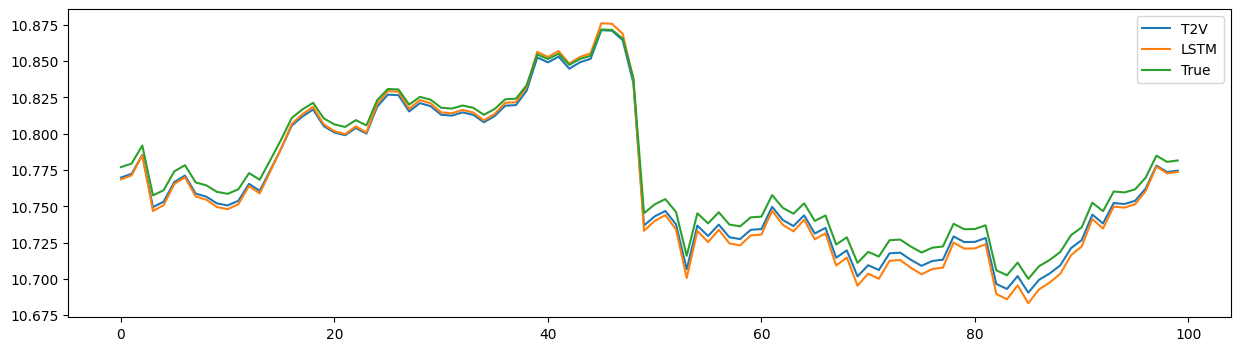

In [16]:
i = randint(101,len(X))

fig, ax = plt.subplots(1,1, figsize=(15, 4))
ax.plot(tsv[-i-100:-i], label="T2V")
ax.plot(lstm[-i-100:-i], label="LSTM")
ax.plot(df.Log_Close.iloc[-i-100:-i].values, label="True")
ax.legend()